<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1</span> Preparation</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-2"><span class="toc-item-num">2</span> Conclusions</a></span></li>

# In search of a toxic comments model

A online store launches a new service. Now users can edit and supplement product descriptions, as in wiki communities. That is, clients offer their edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation.

We will training a model to classify comments into positive and negative. At our disposal is a data set with markup on the toxicity of edits.

We are going to build a model with the value of the quality metric *F1* at least 0.75.

**Instructions for the implementation of the project**

1. Upload and prepare the data.
2. Train different models.
3. Draw conclusions.

It is not necessary to use *BERT* to complete the project, but you can try.

**Data description**

The data is in the file `toxic_comments.csv'. The *text* column in it contains the comment text, and *toxic* is the target attribute.

## Подготовка

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
tqdm.pandas()
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from sklearn.metrics import f1_score
import re
import warnings
warnings.filterwarnings("ignore")
import gc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pinos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pinos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pinos\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [2]:
data = pd.read_csv(r'C:\Users\pinos\Downloads/toxic_comments.csv', index_col=0)

In [3]:
def get_info():
    return data.sample(), data.info()

In [4]:
get_info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


(                                                    text  toxic
 95368  The 40's. Over 60 years ago, that was the norm...      0,
 None)

We have three columns, the first of which seems to be the index, the second is comments, and the third is a rating according to a positive or negative parameter, i.e. 1 and zero.

In [5]:
data.isna().mean()

text     0.0
toxic    0.0
dtype: float64

No missing data in this dataset.

In [6]:
# A function that returns the number of words in a string
def count_words(string):
# Splitting the word
    words = string.split()
    
    # Returns the number of words
    return len(words)

# This create new column with the number of words in the comments
data['transcript'] = data['text'].progress_apply(count_words)

# Printing the average number of words in comments
print(data['transcript'].mean())

  0%|          | 0/159292 [00:00<?, ?it/s]

67.21354493634333


The average volume of comments is 67 words.

In [7]:
toxic=data['toxic'].value_counts()

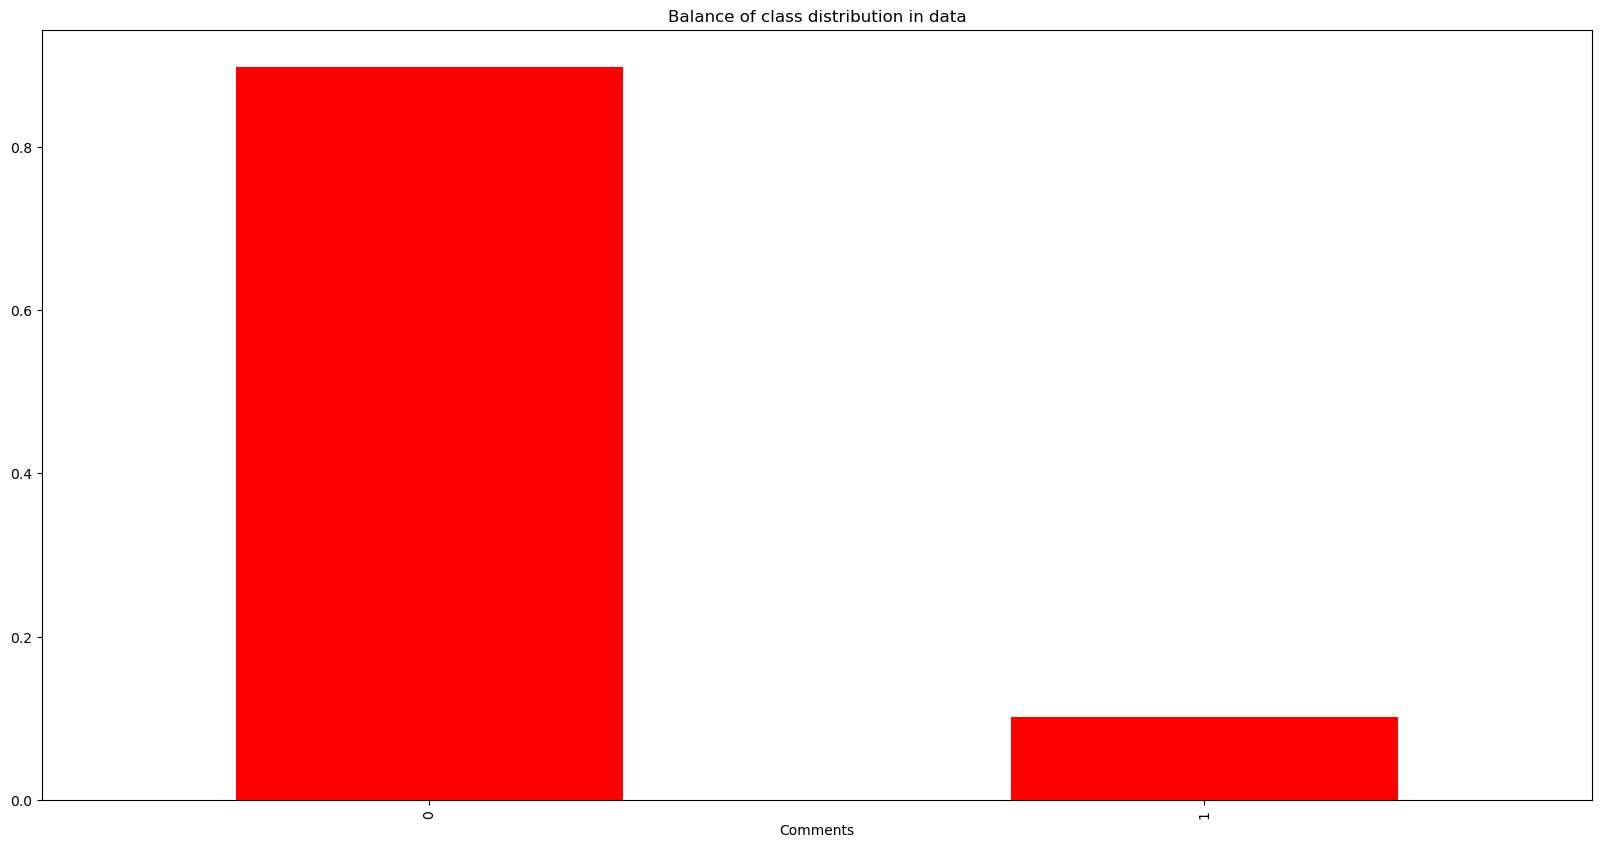

In [8]:
data['toxic'].value_counts(normalize=True).plot(
    kind='bar',figsize=(20, 10), facecolor='red')
plt.title('Balance of class distribution in data')
plt.xlabel('Comments')
plt.show()
plt.show()

It is noteworthy that the values of the column are in a clear imbalance, it seems that negative reviews prevail over positive ones. This should be taken into account when choosing a model for training.

Now we're going to clean up the text a bit with another function.

In [16]:
lemmatizer = WordNetLemmatizer()
def lemmatize(sentence):
    text = re.sub(r'[^a-zA-Z]', ' ', sentence)
    word_list = word_tokenize(text)
    lemmatized_output = " ".join([lemmatizer.lemmatize(w) for w in word_list])
    return " ".join(lemmatized_output.split())

data['lemmatized'] = data['text'].progress_apply(lemmatize)

print(data['lemmatized'][0])

  0%|          | 0/159292 [00:00<?, ?it/s]

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now


In [14]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

We check that the function performs its task.

In [17]:
give_it_a_try = 'Humans cannot communicate; not even their brains can communicate; not even their conscious minds can communicate. Only communication can communicate.'
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(give_it_a_try)])

['Humans', 'can', 'not', 'communicate', ';', 'not', 'even', 'their', 'brain', 'can', 'communicate', ';', 'not', 'even', 'their', 'conscious', 'mind', 'can', 'communicate', '.', 'Only', 'communication', 'can', 'communicate', '.']


In [18]:
corpus = list(data['text'])

In [19]:
%%time

def systemlem(text):
    words = []
    for i in nltk.word_tokenize(text):
        lem = lemmatizer.lemmatize(i, get_wordnet_pos(i))
        words.append(lem)
    return ' '.join(words) 

lemma = []

for i in tqdm(range(len(corpus))):
    
    lemma.append(systemlem(lemmatize(corpus[i])))
    
data['lemma']=data['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 1h 58min 14s
Wall time: 1h 59min 27s


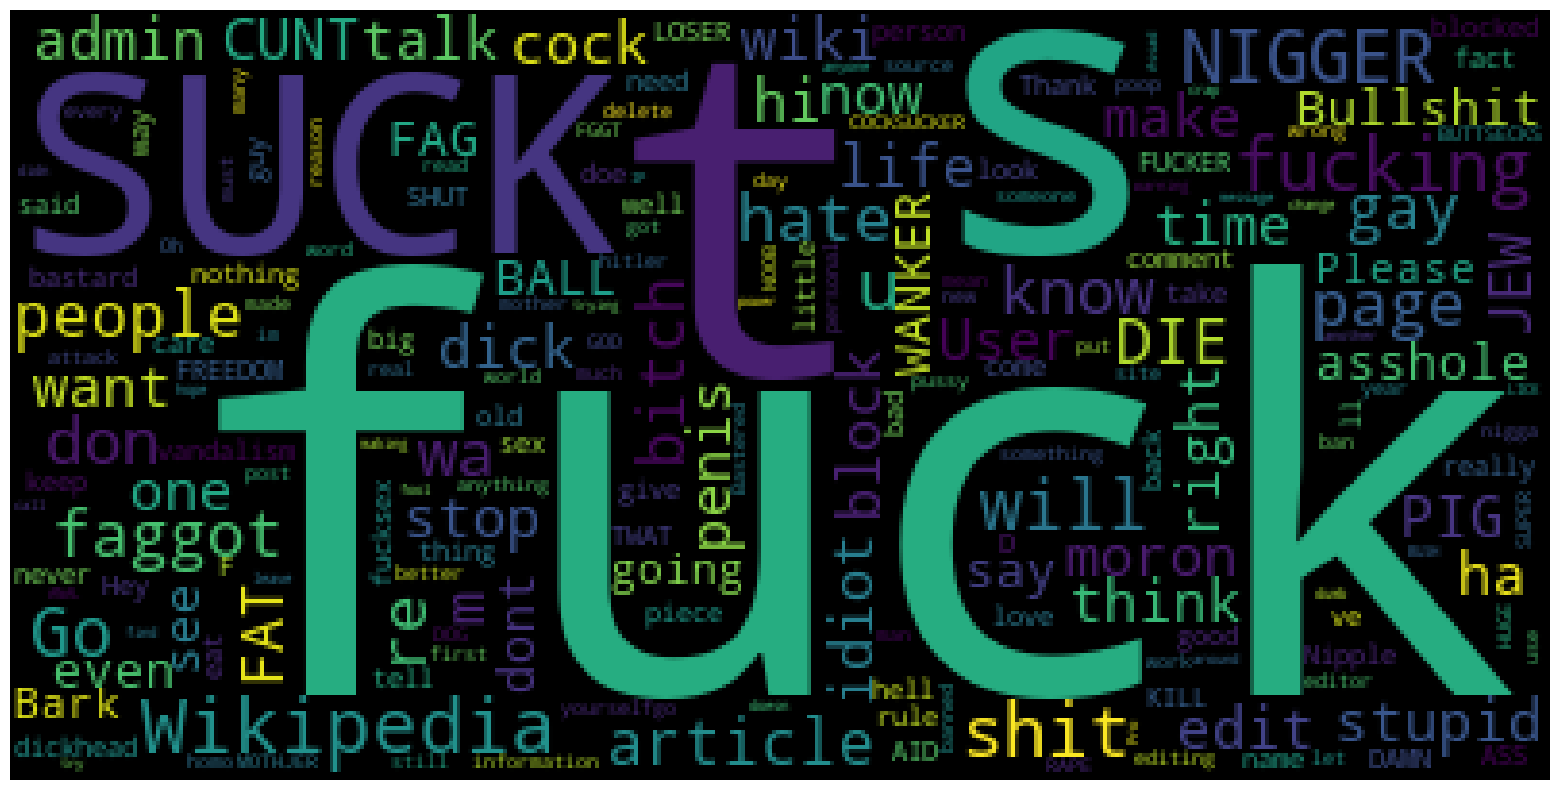

In [20]:
data_toxic = data['lemma'][data['toxic']==1]
text_cloud = ' '.join(data_toxic)
cloud = WordCloud(collocations=False).generate(text_cloud)
plt.figure(figsize=(20,10))
plt.imshow(cloud)
plt.axis('off')
plt.show()   

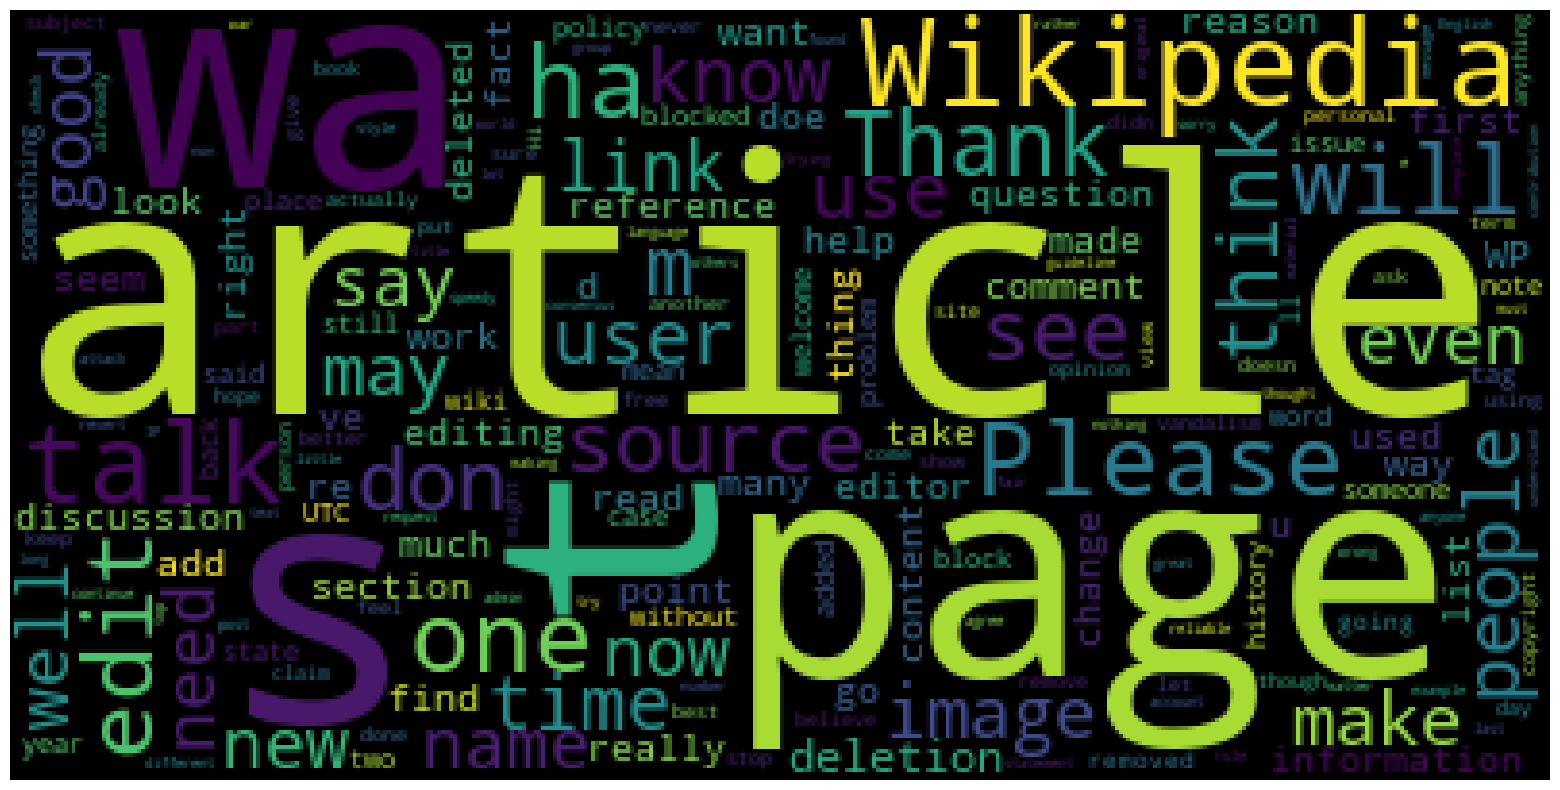

In [21]:
data_positive = data['lemma'][data['toxic']==0]
text_cloud = ' '.join(data_positive)
cloud = WordCloud(collocations=False).generate(text_cloud)
plt.figure(figsize=(20,10))
plt.imshow(cloud)
plt.axis('off')
plt.show()   

We are collecting data as a preliminary stage of training.

In [22]:
target=data['toxic']
features=data.drop(['toxic'], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size = 0.20, random_state=42)


We convert the data and apply stop_words.

In [24]:
corpus_train = X_train['text']
corpus_test = X_test['text']
stop_words = set(stopwords.words('english')) 

Clearing the received data from garbage.

In [25]:
del corpus_train, corpus_test
gc.collect()

1855

We set the search parameters and run a grid search to find the best parameters.

In [26]:
pipe = Pipeline([
    ('vect', CountVectorizer( 
                             dtype=np.float32 
                             )),
    ('tfidf', TfidfTransformer()),
    ('model',MultinomialNB())]) 

In [27]:
parameters_NB = {  
'vect__max_features': (1, 1000)  
}  

In [28]:
grid_search_NB = GridSearchCV(
    pipe,  
    param_grid=parameters_NB, 
    scoring = 'f1',
    n_jobs = 1,
    cv = 5
)

In [29]:
%%time
corpus_train=X_train['text']
grid_search_NB.fit(corpus_train, y_train)    
print('Best parameters: ', grid_search_NB.best_params_ ) 
print('Best score F1 - NB:', grid_search_NB.best_score_ )

Best parameters:  {'vect__max_features': 1000}
Best score F1 - NB: 0.5695507179978125
CPU times: total: 1min 13s
Wall time: 1min 13s


In [30]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'model', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'model__alpha', 'model__class_prior', 'model__fit_prior'])

The results are not very good, they are lower than required.

In [31]:
corpus_train=X_train['text']

In [32]:
%%time
params={'model__random_state': [1, 42, 999, 123456], 
        }
pipeline = Pipeline([
    ('vect', CountVectorizer( 
                             dtype=np.float32, 
                             )),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression(random_state=1, class_weight='balance'))])
grid = GridSearchCV(pipeline, cv=5, param_grid=params,
                    scoring='f1')
grid.fit(corpus_train, y_train)
print('Best parameters LogisticRegression: ', grid.best_params_ ) 
print('Best score F1 - LogisticRegression:', grid.best_score_ )

Best parameters LogisticRegression:  {'model__random_state': 1}
Best score F1 - LogisticRegression: 0.7265389860257058
CPU times: total: 7min 43s
Wall time: 3min 57s


The logistic regression model is also estimated below the required parameters.

In [33]:
%%time
params={  
    'model__random_state': [1,10],
    
 }
pipeline = Pipeline([
    ('vect', CountVectorizer(
                              
                             dtype=np.float32, 
                             )),
    ('tfidf', TfidfTransformer()),
    ('model',LGBMClassifier(scale_pos_weight=3, num_iterations=100
                           ))])
grid = GridSearchCV(pipeline, cv=2, param_grid=params,
                    scoring='f1')
grid.fit(corpus_train, y_train)
print('Best parameters LGBMClassifier: ', grid.best_params_) 
print('Best score F1 - LGBMClassifier:', grid.best_score_)

[LightGBM] [Info] Number of positive: 6492, number of negative: 57224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.864939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418659
[LightGBM] [Info] Number of data points in the train set: 63716, number of used features: 8453
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101890 -> initscore=-2.176403
[LightGBM] [Info] Start training from score -2.176403
[LightGBM] [Info] Number of positive: 6493, number of negative: 57224
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.847941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415601
[LightGBM] [Info] Number of data points in the train set: 63717, number of used features: 8353
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101904 -> initscore=

In [34]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'model', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'model__boosting_type', 'model__class_weight', 'model__colsample_bytree', 'model__importance_type', 'model__learning_rate', 'model__max_depth', 'model__min_child_samples', 'model__min_child_weight', 'model__min_split_gain', 'model__n_estimators', 'model__n_jobs', 'model__num_leaves', 'model__objective', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__subsample', 'model__subsample_for_bin', 'model__subsample_freq', 'model__scale_pos_weight', 'model__num_iterations'])

The result of the GSM Classifier is more than 76 percent.

In [35]:
estimator = CatBoostClassifier(random_state=1, 
                               scale_pos_weight=3, 
                               n_estimators=100, 
                               learning_rate=0.1, 
                               thread_count=-1,
                               depth=3)

In [36]:
%%time
params={'model__random_state': [1,10],
        }       
pipeline = Pipeline([
    ('vect', CountVectorizer(
                             dtype=np.float32, 
                             )),
    ('tfidf', TfidfTransformer()),
    ('model', estimator)])
grid = GridSearchCV(pipeline, cv=5, param_grid=params,
                    scoring='f1')
grid.fit(corpus_train, y_train)
print('Best parameters CatBoostClassifier: ', grid.best_params_ ) 
print('Best score F1 - CatBoostClassifier: ', grid.best_score_ )

0:	learn: 0.6394901	total: 628ms	remaining: 1m 2s
1:	learn: 0.6008843	total: 1.1s	remaining: 54s
2:	learn: 0.5689512	total: 1.56s	remaining: 50.4s
3:	learn: 0.5458975	total: 2.03s	remaining: 48.8s
4:	learn: 0.5251785	total: 2.56s	remaining: 48.6s
5:	learn: 0.5078716	total: 3.01s	remaining: 47.2s
6:	learn: 0.4944862	total: 3.46s	remaining: 46s
7:	learn: 0.4822693	total: 3.95s	remaining: 45.5s
8:	learn: 0.4713919	total: 4.43s	remaining: 44.8s
9:	learn: 0.4618802	total: 4.95s	remaining: 44.5s
10:	learn: 0.4534486	total: 5.4s	remaining: 43.7s
11:	learn: 0.4462114	total: 5.85s	remaining: 42.9s
12:	learn: 0.4404469	total: 6.29s	remaining: 42.1s
13:	learn: 0.4340130	total: 6.8s	remaining: 41.8s
14:	learn: 0.4288394	total: 7.27s	remaining: 41.2s
15:	learn: 0.4247392	total: 7.73s	remaining: 40.6s
16:	learn: 0.4202207	total: 8.19s	remaining: 40s
17:	learn: 0.4161923	total: 8.71s	remaining: 39.7s
18:	learn: 0.4126860	total: 9.22s	remaining: 39.3s
19:	learn: 0.4091184	total: 9.7s	remaining: 38.8s


The CatBoost model with 67 percent also does not meet the minimum level required for this task.

In [37]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'model', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'model__learning_rate', 'model__depth', 'model__n_estimators', 'model__random_state', 'model__scale_pos_weight'])

Мы перешли к тестированию лучшей модели, которая оказалась классификатором ЛГБМ.

In [38]:
corpus_test = X_test['text']

In [40]:
%%time
params={  
    'tfidf__smooth_idf': [True, False],
     
 }
pipeline = Pipeline([
    ('vect', CountVectorizer( 
                             dtype=np.float32,  
                             
                             )),
    ('tfidf', TfidfTransformer()),
    ('model',LGBMClassifier(random_state=1,
                            scale_pos_weight=3, 
                            num_threads=4,
                            learning_rate=0.2,
                            max_depth=3,
                            n_estimators=1000,
                            num_iterations=700,
                            boosting_type='gbdt',
                            num_leaves=40,
                            silent=True,                                                   
                           ))])
grid = GridSearchCV(pipeline, cv=5, param_grid=params,
                    scoring='f1')
grid.fit(corpus_train, y_train)
predictions=grid.predict(corpus_test)
print('Best parameters LGBMClassifier: ', grid.best_params_) 
print('Score F1 at the test phase - LGBMClassifier:', grid.best_score_)
test_score = f1_score(y_test, predictions)
print('Final score F1 : ', test_score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 10388, number of negative: 91558
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.794674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 591015
[LightGBM] [Info] Number of data points in the train set: 101946, number of used features: 11215
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101897 -> initscore=-2.176321
[LightGBM] [Info] Start training from score -2.176321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

## Conclusions

Three classification models - NB, Logistic regression and Catboost models, even with optimized parameter search, failed to achieve the criteria required to get 75 percent of the points in F1.

The NB model scored 57 points for the account, the LogisticRegression model scored more points-72 percent, and the Catboost model-67 percent.

The LightBoost model, however, was 76 percent higher than the criteria we set at the beginning of the study. At the testing stage and after a long and thorough search for hyperparameters, we managed to reach almost 79 percent.

The latter, therefore, is the model we recommend for analyzing comments.